# Simulated annealing para sudoku

Trabajo basado en el paper "Metaheuristics can solve sudoku puzzles" de Lewis, Rhyd.  
Link al paper: https://link.springer.com/article/10.1007/s10732-007-9012-8.

 #### Integrantes:  
 -Santiago Rebolledo  
 -Domingo ruiz  
 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

Importamos un dataset de 1 millon de sudokus junto a sus soluciones. Estos fueron generados algorítmicamente y obtenidos
de kaggle: https://www.kaggle.com/datasets/bryanpark/sudoku.

In [2]:
sudokus = pd.read_csv(r"sudoku.csv")

In [3]:
sudokus.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [4]:
#Comprobamos que el largo de nuestros datos sea 81
len(sudokus.loc[4][1])

81

In [5]:
#tamaño del dataset
len(sudokus)

1000000

### Cambio de formato

Buscamos cambiar el formato de nuestros datos de string a un arreglo de $9x9$.

In [6]:
#Recibe un sudoku en forma de sting y debe convertirlo a forma de matriz de 9x9. Se espera que str tenga 81 caracteres.
def strToArr(str): 
    arr = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            arr[i][j]=str[9*i+j]
    return arr
        

In [7]:
sud1=sudokus.loc[4][1]
arr = strToArr(sud1)
print(arr)
print(sud1)

[[4. 6. 5. 9. 1. 2. 3. 7. 8.]
 [1. 8. 9. 4. 7. 3. 5. 6. 2.]
 [3. 2. 7. 5. 6. 8. 1. 4. 9.]
 [7. 3. 8. 6. 4. 5. 2. 9. 1.]
 [9. 5. 4. 8. 2. 1. 6. 3. 7.]
 [2. 1. 6. 3. 9. 7. 8. 5. 4.]
 [5. 7. 3. 2. 8. 4. 9. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 8. 3.]
 [8. 9. 1. 7. 3. 6. 4. 2. 5.]]
465912378189473562327568149738645291954821637216397854573284916642159783891736425


### Función de costo

Para utilizar Simulated Annealing, necesitamos una función de costo. 
Dado un sudoku su costo corresponderá a la cantidad de repeticiones de números que 
se encuentren en filas y columnas (Nos aseguramos de que no hayan repeticiones en los cuadrados de $3x3$).  
Primero definimos una función auxiliar para alivianar el código que viene en las siguientes 2 secciones.

In [8]:
#Recibe arreglo arr de largo 9 y devuelve arreglo con los numeros en [9] que NO estan en arr.
def missingNums(arr): 
    nums = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    a=0
    for i in range(9):
        if i+1 in arr:
            nums.pop(i-a)
            a+=1
    return nums

In [9]:
#Recibe un sudoku en formato de arreglo 9x9 y devuelve el numero de repeticiones 
#que se encuentran entre lineas y columnas. Esto equivale a entregar la cantidad de numeros que no aparecen 
#en dicha fila o columna.
def costo(arr):
    costo = 0
    for i in range(9):
        costo+=len(missingNums(arr[i]))+len(missingNums(arr[:,i])) #sumamos cada numero que falta en la columna i y fila i
    return costo

In [10]:
#testeamos función de costo en un sudoku completo
sud1=sudokus.loc[4][1]
arr1 = strToArr(sud1)
print(arr1)
print(costo(arr1))

[[4. 6. 5. 9. 1. 2. 3. 7. 8.]
 [1. 8. 9. 4. 7. 3. 5. 6. 2.]
 [3. 2. 7. 5. 6. 8. 1. 4. 9.]
 [7. 3. 8. 6. 4. 5. 2. 9. 1.]
 [9. 5. 4. 8. 2. 1. 6. 3. 7.]
 [2. 1. 6. 3. 9. 7. 8. 5. 4.]
 [5. 7. 3. 2. 8. 4. 9. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 8. 3.]
 [8. 9. 1. 7. 3. 6. 4. 2. 5.]]
0


In [11]:
#testeamos función de costo en un sudoku aun sin completar
sud2 = sudokus.loc[4][0]
arr2 = strToArr(sud2)
print(arr2)
print(costo(arr2))

[[0. 0. 5. 9. 1. 0. 3. 0. 8.]
 [0. 0. 9. 4. 0. 3. 0. 6. 0.]
 [0. 2. 7. 5. 0. 0. 1. 0. 0.]
 [0. 3. 0. 0. 0. 0. 2. 0. 1.]
 [0. 0. 0. 8. 2. 0. 0. 0. 7.]
 [0. 0. 6. 0. 0. 7. 0. 0. 4.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [6. 4. 0. 1. 5. 0. 7. 0. 0.]
 [8. 9. 0. 0. 0. 0. 4. 2. 0.]]
98


El costo $98$ tiene sentido pues en el sudoku aún sin completar hay $49$ ceros.

### Función para rellenar sudoku

In [12]:
#Debe rellenar el sudoku de manera aleatoria pero respetando la condicion de que los 9 numeros esten presentes en cada cuadrado

def rellenar(sudoku): 
    #No queremos modificar nuestro arreglo original con la funcion rellenar. Para ello creamos una copia:
    a = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            a[i][j]=sudoku[i][j]
            
    cuadrado = np.zeros(9)        
    for i in range(3): #debemos visitar cada cuadrado (i, j) y modificar los valores 0 de sus entradas
        for j in range(3):
            s=0
            #recuperamos cuadrado(i,j)
            for k in range(3):
                for l in range(3):
                    cuadrado[3*k+l]=a[3*i+l][3*j+k]
                    
            #lo rellenamos al azar
            arr = missingNums(cuadrado)
            random.shuffle(arr)
            for k in range(3):
                for l in range(3):
                    if a[3*i+l][3*j+k]==0:
                        a[3*i+l][3*j+k]=arr[s]
                        s+=1
    return a

In [13]:
print(arr2)

[[0. 0. 5. 9. 1. 0. 3. 0. 8.]
 [0. 0. 9. 4. 0. 3. 0. 6. 0.]
 [0. 2. 7. 5. 0. 0. 1. 0. 0.]
 [0. 3. 0. 0. 0. 0. 2. 0. 1.]
 [0. 0. 0. 8. 2. 0. 0. 0. 7.]
 [0. 0. 6. 0. 0. 7. 0. 0. 4.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [6. 4. 0. 1. 5. 0. 7. 0. 0.]
 [8. 9. 0. 0. 0. 0. 4. 2. 0.]]


In [14]:
a = rellenar(arr2)
print(a)

[[8. 6. 5. 9. 1. 8. 3. 2. 8.]
 [1. 4. 9. 4. 6. 3. 7. 6. 4.]
 [3. 2. 7. 5. 7. 2. 1. 9. 5.]
 [5. 3. 1. 5. 1. 3. 2. 5. 1.]
 [9. 2. 8. 8. 2. 4. 3. 8. 7.]
 [4. 7. 6. 9. 6. 7. 9. 6. 4.]
 [1. 5. 7. 3. 8. 6. 3. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 9. 8.]
 [8. 9. 3. 2. 4. 7. 4. 2. 5.]]


### Función para permutar dos coordenadas del sudoku

In [15]:
def gen_random_numbers_in_range(low, high, n): #Código obtenido de internet. Genera n numeros 
                                               #aleatorios distintos en el intervalo [low,high)
    return random.sample(range(low, high), n)

In [16]:
#La función necesita del sudoku original más el rellenado. 
#Con el sudoku original sabrá que coordenadas está permitido permutar.
def permutarCoords(rell, orig):
    k, l = np.random.randint(3, size=2) #seleccionamos cuadrado donde realizar permutacion
    coord = []
    copia = np.copy(rell) 
    for i in range(3):
        for j in range(3):
            if orig[3*k+i][3*l+j]==0:
                coord.append(3*i+j)
    r, s = gen_random_numbers_in_range(0, len(coord), 2)
    
    #intercambiamos coordenadas
    a = copia[3*k+coord[r]//3][3*l+coord[r]%3]
    copia[3*k+coord[r]//3][3*l+coord[r]%3]=copia[3*k+coord[s]//3][3*l+coord[s]%3]
    copia[3*k+coord[s]//3][3*l+coord[s]%3]=a
    
    return copia

In [17]:
print(arr2)

[[0. 0. 5. 9. 1. 0. 3. 0. 8.]
 [0. 0. 9. 4. 0. 3. 0. 6. 0.]
 [0. 2. 7. 5. 0. 0. 1. 0. 0.]
 [0. 3. 0. 0. 0. 0. 2. 0. 1.]
 [0. 0. 0. 8. 2. 0. 0. 0. 7.]
 [0. 0. 6. 0. 0. 7. 0. 0. 4.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [6. 4. 0. 1. 5. 0. 7. 0. 0.]
 [8. 9. 0. 0. 0. 0. 4. 2. 0.]]


In [18]:
print(a)

[[8. 6. 5. 9. 1. 8. 3. 2. 8.]
 [1. 4. 9. 4. 6. 3. 7. 6. 4.]
 [3. 2. 7. 5. 7. 2. 1. 9. 5.]
 [5. 3. 1. 5. 1. 3. 2. 5. 1.]
 [9. 2. 8. 8. 2. 4. 3. 8. 7.]
 [4. 7. 6. 9. 6. 7. 9. 6. 4.]
 [1. 5. 7. 3. 8. 6. 3. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 9. 8.]
 [8. 9. 3. 2. 4. 7. 4. 2. 5.]]


In [19]:
print(permutarCoords(a, arr2))

[[8. 6. 5. 9. 1. 8. 3. 2. 8.]
 [1. 4. 9. 4. 6. 3. 7. 6. 9.]
 [3. 2. 7. 5. 7. 2. 1. 4. 5.]
 [5. 3. 1. 5. 1. 3. 2. 5. 1.]
 [9. 2. 8. 8. 2. 4. 3. 8. 7.]
 [4. 7. 6. 9. 6. 7. 9. 6. 4.]
 [1. 5. 7. 3. 8. 6. 3. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 9. 8.]
 [8. 9. 3. 2. 4. 7. 4. 2. 5.]]


### Simulated annealing

Ya tenemos todas las herramientas para utilizar simulated annealing en el problema.  
Cómo función de temperatura usaremos una secuencia geométrica $t_{i+1}=\alpha t_i$ con $0<\alpha<1$. Para definir la temperatura inicial simulamos 200 estados iniciales en el sudoku y tomamos $t_0$ como la desviación estandar de la función de costo en esos 200 estados.  
Nuestra probabilidad de aceptación para pasar de un estado $s$ a un estado adyacente $r$, tomando $\Delta = costo(r)-costo(s)$, será:
$$ 
P(\text{r es aceptado})= \begin{cases}
      1 & \text{si} \quad \Delta \leq 0\\
      exp(-\frac{\Delta}{T}) & \text{si} \quad \Delta > 0\\
      \end{cases}  
      $$


In [20]:
#Función que dado un sudoku me entregue la temperatura inicial
def tempInicial(sudoku):
    std = np.zeros(200)
    for i in range(200):
        a = rellenar(sudoku)
        std[i] = costo(a)
    return np.std(std)

#Cada reducción de temperatura se realizará tras hacer n intercambios, con n la cantidad de casillas vacías
#que tiene nuestro sudoku en su estado inicial.
def casillasVacias(sudoku):
    n=0
    for i in range(9):
        for j in range(9):
            if sudoku[i][j]==0:
                n+=1
    return n

In [21]:

#Recibe un sudoku con ciertas casillas fijas e intenta completarlo.
#alpha es la tasa de enfriamiento. N el numero máximo de etapas que se realizarán antes de detener el algoritmo.
def simAnnealing(sudoku, alpha, N): 
    n = casillasVacias(sudoku)
    T = tempInicial(sudoku)
    a = rellenar(sudoku)
    
    for i in range(N):
        if costo(a)==0:
            return a, costo(a), i*j
        for j in range(n):
            b = permutarCoords(a, sudoku)
            delta = costo(b)-costo(a)
            if delta<=0:
                a = np.copy(b)
            else: 
                if np.exp(-delta/T)>np.random.uniform():
                    a = np.copy(b)
        T=alpha*T
        
    return a, costo(a), i*j

In [22]:
A = simAnnealing(arr2, 0.99, 10000)
print("El algoritmo terminó en "+str(A[2])+" iteraciones")
print("Solución:")
print(A[0])

El algoritmo terminó en 11424 iteraciones
Solución:
[[4. 6. 5. 9. 1. 2. 3. 7. 8.]
 [1. 8. 9. 4. 7. 3. 5. 6. 2.]
 [3. 2. 7. 5. 6. 8. 1. 4. 9.]
 [7. 3. 8. 6. 4. 5. 2. 9. 1.]
 [9. 5. 4. 8. 2. 1. 6. 3. 7.]
 [2. 1. 6. 3. 9. 7. 8. 5. 4.]
 [5. 7. 3. 2. 8. 4. 9. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 8. 3.]
 [8. 9. 1. 7. 3. 6. 4. 2. 5.]]


In [23]:
#Comparamos con la solución del dataset
sol2 = sudokus.loc[4][1]
sol22= strToArr(sol2)
print(sol22)

[[4. 6. 5. 9. 1. 2. 3. 7. 8.]
 [1. 8. 9. 4. 7. 3. 5. 6. 2.]
 [3. 2. 7. 5. 6. 8. 1. 4. 9.]
 [7. 3. 8. 6. 4. 5. 2. 9. 1.]
 [9. 5. 4. 8. 2. 1. 6. 3. 7.]
 [2. 1. 6. 3. 9. 7. 8. 5. 4.]
 [5. 7. 3. 2. 8. 4. 9. 1. 6.]
 [6. 4. 2. 1. 5. 9. 7. 8. 3.]
 [8. 9. 1. 7. 3. 6. 4. 2. 5.]]


In [24]:
sud3 = sudokus.loc[130][0]
arr3 = strToArr(sud3)
sol3 = sudokus.loc[130][1]
sol33 = strToArr(sol3)

In [25]:
A1 = simAnnealing(arr3, 0.5, 10000)
print("El algoritmo terminó en "+str(A1[2])+" iteraciones")
print("Solución:")
print(A1[0])

El algoritmo terminó en 1196 iteraciones
Solución:
[[3. 8. 5. 9. 6. 2. 4. 7. 1.]
 [4. 7. 9. 8. 3. 1. 5. 2. 6.]
 [1. 2. 6. 7. 4. 5. 9. 3. 8.]
 [9. 3. 1. 4. 5. 8. 7. 6. 2.]
 [7. 4. 2. 6. 1. 3. 8. 5. 9.]
 [6. 5. 8. 2. 7. 9. 1. 4. 3.]
 [2. 1. 4. 5. 9. 6. 3. 8. 7.]
 [8. 9. 7. 3. 2. 4. 6. 1. 5.]
 [5. 6. 3. 1. 8. 7. 2. 9. 4.]]


In [26]:
#Comparamos con la solución del dataset
print(sol33)

[[3. 8. 5. 9. 6. 2. 4. 7. 1.]
 [4. 7. 9. 8. 3. 1. 5. 2. 6.]
 [1. 2. 6. 7. 4. 5. 9. 3. 8.]
 [9. 3. 1. 4. 5. 8. 7. 6. 2.]
 [7. 4. 2. 6. 1. 3. 8. 5. 9.]
 [6. 5. 8. 2. 7. 9. 1. 4. 3.]
 [2. 1. 4. 5. 9. 6. 3. 8. 7.]
 [8. 9. 7. 3. 2. 4. 6. 1. 5.]
 [5. 6. 3. 1. 8. 7. 2. 9. 4.]]


Observamos que nuestro algoritmo consigue resolver los sudokus, para estas 2 instancias particulares. En el caso en que $\alpha=0.99$ se necesitaron considerablemente más iteraciones para encontrar la solución que cuando $\alpha=0.5$. Esto apunta hacia que el algoritmo no tiene tanto riesgo de quedarse atrapado en mínimos locales. Anlizamos esto en más detalle en la sección siguiente.

Por último testeamos nuestro algoritmo en el sudoku en dificultad difícil del newyork times.

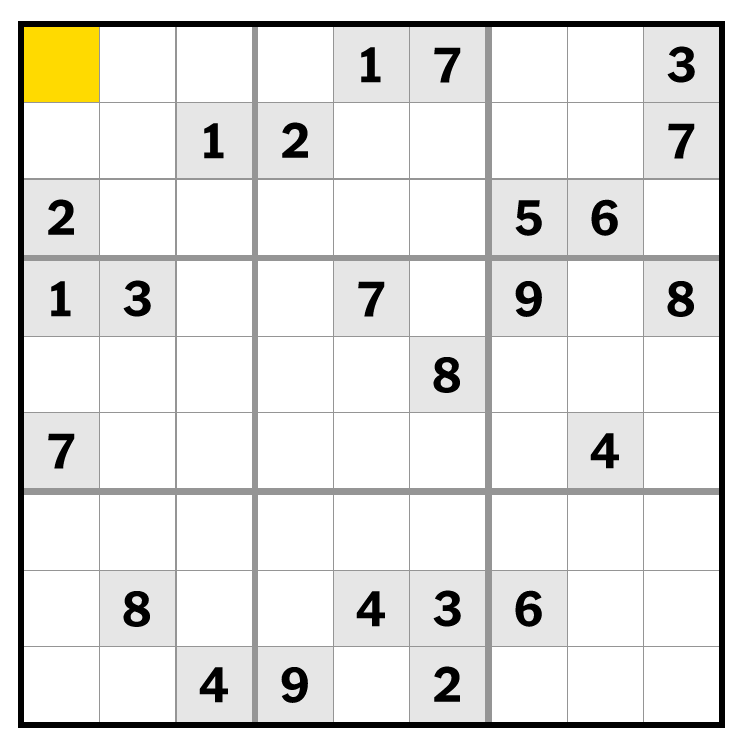

In [27]:
NYT=[[0,0,0,0,1,7,0,0,3], 
     [0,0,1,2,0,0,0,0,7], 
     [2,0,0,0,0,0,5,6,0], 
     [1,3,0,0,7,0,9,0,8], 
     [0,0,0,0,0,8,0,0,0],
     [7,0,0,0,0,0,0,4,0],
     [0,0,0,0,0,0,0,0,0],
     [0,8,0,0,4,3,6,0,0],
     [0,0,4,9,0,2,0,0,0]]
solNYT=simAnnealing(NYT, 0.9, 1000)
print(solNYT[1])
print(solNYT[0])

2
[[8. 4. 5. 6. 1. 7. 2. 9. 3.]
 [6. 9. 1. 2. 3. 5. 4. 8. 7.]
 [2. 7. 3. 8. 9. 4. 5. 6. 1.]
 [1. 3. 2. 4. 7. 6. 9. 5. 8.]
 [4. 6. 9. 1. 5. 8. 7. 3. 2.]
 [7. 5. 8. 3. 2. 9. 1. 4. 6.]
 [5. 2. 6. 7. 8. 1. 3. 4. 9.]
 [9. 8. 7. 5. 4. 3. 6. 2. 1.]
 [3. 1. 4. 9. 6. 2. 8. 7. 5.]]


Observamos que nuestro algoritmo no es capaz de resolver este puzle y se queda estancado en un mínimo local. Una posible solución a ello sería reiniciar el algoritmo si no se observan cambios en el valor del costo en cierta cantidad de iteraciones.

### Análisis de resultados

Analizamos para distintos valores de $\alpha$ cuantas iteraciones promedio le toma al algoritmo resolver cada sudoku para los primeros $10$ sudokus del dataset.

In [28]:
alphas=[0.1, 0.3, 0.5, 0.7, 0.9]
iterprom=np.zeros(5)
prom = 0
for i in range(5):
    m=0
    costos=np.zeros(10)
    for j in range(10):
        sud=sudokus.loc[j][0]
        arr=strToArr(sud)
        A2 = simAnnealing(arr, alphas[i], 500)
        costos[j]=A2[1]
        if A2[1]==0: 
            prom+=A2[2]
            m+=1
    iterprom[i]=prom/m
    print("Arreglo de costos para alpha="+str(0.1+i*0.2)+":"+str(costos))
    


C:\Users\nico_\AppData\Local\Temp\ipykernel_956\2727500996.py:17: RuntimeWarning: overflow encountered in double_scalars
  if np.exp(-delta/T)>np.random.uniform():
C:\Users\nico_\AppData\Local\Temp\ipykernel_956\2727500996.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-delta/T)>np.random.uniform():


Arreglo de costos para alpha=0.1:[0. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
Arreglo de costos para alpha=0.30000000000000004:[2. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
Arreglo de costos para alpha=0.5:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arreglo de costos para alpha=0.7000000000000001:[0. 5. 0. 2. 0. 4. 0. 0. 0. 0.]
Arreglo de costos para alpha=0.9:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


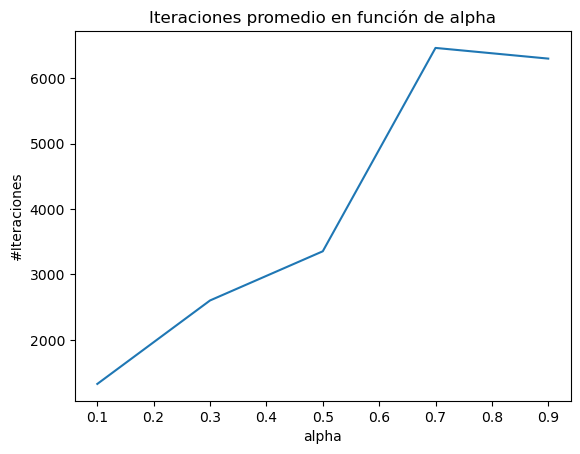

In [29]:
plt.plot(alphas, iterprom)
plt.title("Iteraciones promedio en función de alpha")
plt.xlabel("alpha")
plt.ylabel("#Iteraciones")
plt.show()

Observamos que el número de iteraciones promedio crece proporcionalmente con $\alpha$. Sin embargo para los primeros 3 valores de $\alpha$ ($0.1, 0.3, 0.5$) tenemos $2$ de $10$ sudokus a los que no se les encontró solución, mientras que cuando $\alpha=0.7$ hay solo $1$ y cuando $\alpha=0.9$ todos son resueltos. Luego un aumento en el valor de $\alpha$ significó más iteraciones en promedio pero también una mayor consistencia encontrando soluciones a los sudokus.
